In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import resize

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms

from network.net import VGG, make_layers
from network.utils import Flatten, accuracy

In [2]:
def vgg19():
    model = VGG(make_layers())
    state_dict = torch.load('ignore/vgg19-dcbb9e9d.pth')
    model.load_state_dict(state_dict)
    return model

In [3]:
model = vgg19()
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [4]:
#freeze layers
for param in model.parameters():
    param.requires_grad = False

#modify the last two convolutions
model.features[-5] = nn.Conv2d(512,512,3, padding=1)
model.features[-3] = nn.Conv2d(512,2,3, padding=1)

#remove fully connected layer and replace it with AdaptiveAvePooling
model.classifier = nn.Sequential(
                                nn.AdaptiveAvgPool2d(1),Flatten(),
                                nn.LogSoftmax()
                                )

In [5]:
#Create datasets and dataloaders

input_size=224
batch_size = 16
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

dataset_train = datasets.ImageFolder(root='hymenoptera_data/train/',
                                    transform=train_transforms)

dataset_valid = datasets.ImageFolder(root='hymenoptera_data/val/',
                                    transform=valid_transforms)



train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1)

valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1)

In [6]:
criterion = nn.CrossEntropyLoss()
lr =.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [8]:
mean_train_losses = []
mean_val_losses = []

mean_train_acc = []
mean_val_acc = []
minLoss = 99999
maxValacc = -99999
for epoch in range(100):
    print('EPOCH: ',epoch+1)
#     train_losses = []
#     val_losses = []    
    train_acc = []
    val_acc = []
    
    running_loss = 0.0
    
    model.train()
    count = 0
    for images, labels in train_loader:        
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        
        outputs = model(images) 
        
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        
        train_acc.append(accuracy(outputs, labels))
        
        
        loss.backward()
        optimizer.step()        
        
        running_loss += loss.item()
        count +=1
    
    print('Training loss:.......', running_loss/count)
    mean_train_losses.append(running_loss/count)
        
    model.eval()
    count = 0
    val_running_loss = 0.0
    for images, labels in valid_loader:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_acc.append(accuracy(outputs, labels))
        val_running_loss += loss.item()
        count +=1

    mean_val_loss = val_running_loss/count
    print('Validation loss:.....', mean_val_loss)
    
    print('Training accuracy:...', np.mean(train_acc))
    print('Validation accuracy..', np.mean(val_acc))
    
    mean_val_losses.append(mean_val_loss)
    
    mean_train_acc.append(np.mean(train_acc))
    
    val_acc_ = np.mean(val_acc)
    mean_val_acc.append(val_acc_)
    
   
    if mean_val_loss < minLoss:
        torch.save(model.state_dict(), 'bees2.pth' )
        print(f'NEW BEST Val Loss: {mean_val_loss} ........old best:{minLoss}')
        minLoss = mean_val_loss
        print('')
        
    if val_acc_ > maxValacc:
        torch.save(model.state_dict(), 'acc_bees2.pth' )
        print(f'NEW BEST Val Acc: {val_acc_} ........old best:{maxValacc}')
        maxValacc = val_acc_
    
    
    print('')
    

This was the best validation accuracy result from 200 epochs

EPOCH:  94
Training loss:....... 0.05045163659378886
Validation loss:..... 0.32856482395509373
Training accuracy:... 0.9791666666666666
Validation accuracy.. 0.95625
NEW BEST Val Acc: 0.95625 ........old best:0.945138888888889


In [9]:
class SaveFeatures():
    features=None
    def __init__(self,m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [28]:
model = vgg19()
model.features[-5] = nn.Conv2d(512,512,3, padding=1)
model.features[-3] = nn.Conv2d(512,2,3, padding=1)    
model.classifier = nn.Sequential(
                                nn.AdaptiveAvgPool2d(1),Flatten(),
                                nn.LogSoftmax()
                                )

In [31]:
state_dict = torch.load('results/acc_bees1.pth')
model.load_state_dict(state_dict)
model.eval()
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [32]:
sf = SaveFeatures(model.features[-3])

In [33]:
#change batch size to 1 to grab one image at a time
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=1, 
                                          shuffle=True,
                                          num_workers=1)

In [36]:
sf = SaveFeatures(model1.features[-3])
im, lab = next(iter(valid_loader))
print(im.shape)
img = im
im = Variable(im.cuda())
lab = Variable(lab.cuda())
outputs = model1(im)
res = accuracy(outputs, lab)

print(res)
if res==1:
    print('correct')  
    print('label', lab.data)
else: print('wrong', lab.data)

torch.Size([1, 3, 224, 224])
1.0
correct
label tensor([0], device='cuda:0')


In [37]:
#from Pytorch transfer learning tutorial
def imshow_(image_in, title=None):
    """Imshow for Tensor."""
    img = np.rollaxis(image_in.squeeze().cpu().detach().numpy(),0,3)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    return img

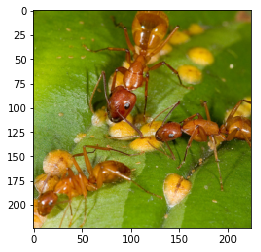

In [38]:
bee_ant = imshow_(img)

In [39]:
sf.remove()
arr = sf.features.cpu().detach().numpy()
arr1 = arr[0]

In [44]:
ans = np.dot(np.rollaxis(arr1,0,3), [1,0])

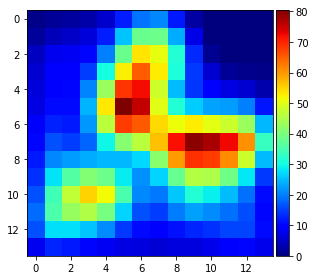

In [45]:
imshow(ans, cmap='jet')

In [46]:
from skimage.transform import resize
a = resize(ans, (224,224))

<Figure size 432x288 with 0 Axes>

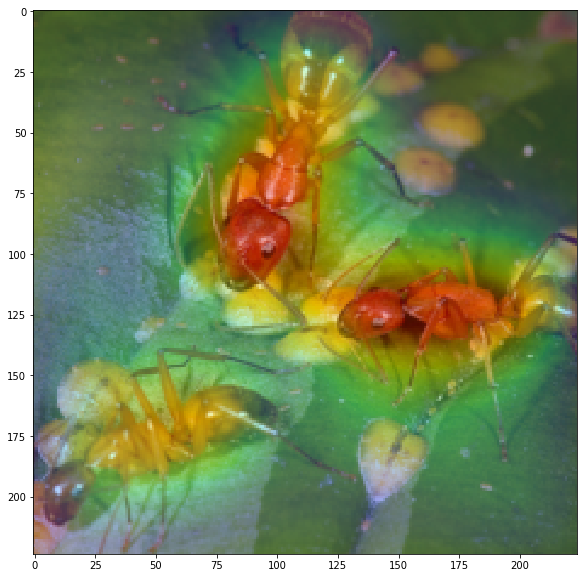

In [47]:
plt.figure()
plt.subplots(figsize=(10,10))
plt.imshow(bee_ant)
plt.imshow(a, alpha=.3, cmap='jet')
plt.show()